In [1]:
import os

# os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/drhead/miniconda3/envs/sam_hq_xla/lib:/usr/local/cuda/targets/x86_64-linux/lib'
os.environ['PT_XLA_DEBUG'] = '1' 
os.environ['PT_XLA_DEBUG_FILE'] = './xla_debug.txt'
os.environ['PJRT_DEVICE'] = 'TPU'

# Nonzero op lowering is unstable but seems to work for some ops
# os.environ['XLA_EXPERIMENTAL'] = 'nonzero'

# Will cast torch.float and torch.double to BF16
os.environ['XLA_USE_BF16'] = '1'

os.environ['XLA_EMIT_STEPLOG'] = '1'
# Will cast torch.float to BF16 and torch.double to float32
# os.environ['XLA_DOWNCAST_BF16'] = '1'
os.environ['XLA_IR_DEBUG'] = '1'
os.environ['XLA_HLO_DEBUG'] = '1'
os.environ['MASTER_PORT'] = '29500'

import numpy as np
import torch
print("PyTorch version:", torch.__version__)
import torch_xla.core.xla_model as xm

import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_backend
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.experimental.pjrt_backend
import torch_xla.experimental.pjrt as pjrt
import matplotlib.pyplot as plt
import cv2
import time

import torch_xla.debug.profiler as xp
import torch_xla.utils.utils as xu
import multiprocessing

# !git clone -b xla https://github.com/drhead/sam-hq.git
# os.chdir('sam-hq')
# !export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

PyTorch version: 2.1.0


In [2]:
#!mkdir pretrained_checkpoint
#!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth
#!mv sam_hq_vit_h.pth pretrained_checkpoint


In [3]:
def show_anns(anns, valid_masks, count):
    if count== 0:
        return

    valid_anns = anns.squeeze(0)[valid_masks[0:count]]  # Filter out invalid masks
    if count == 0:
        return
    print(valid_anns.shape)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((valid_anns.shape[1], valid_anns.shape[2], 4))
    img[:,:,3] = 0
    print(img.shape)
    for ann in valid_anns:
        m = ann.cpu()
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

(512, 512, 3)


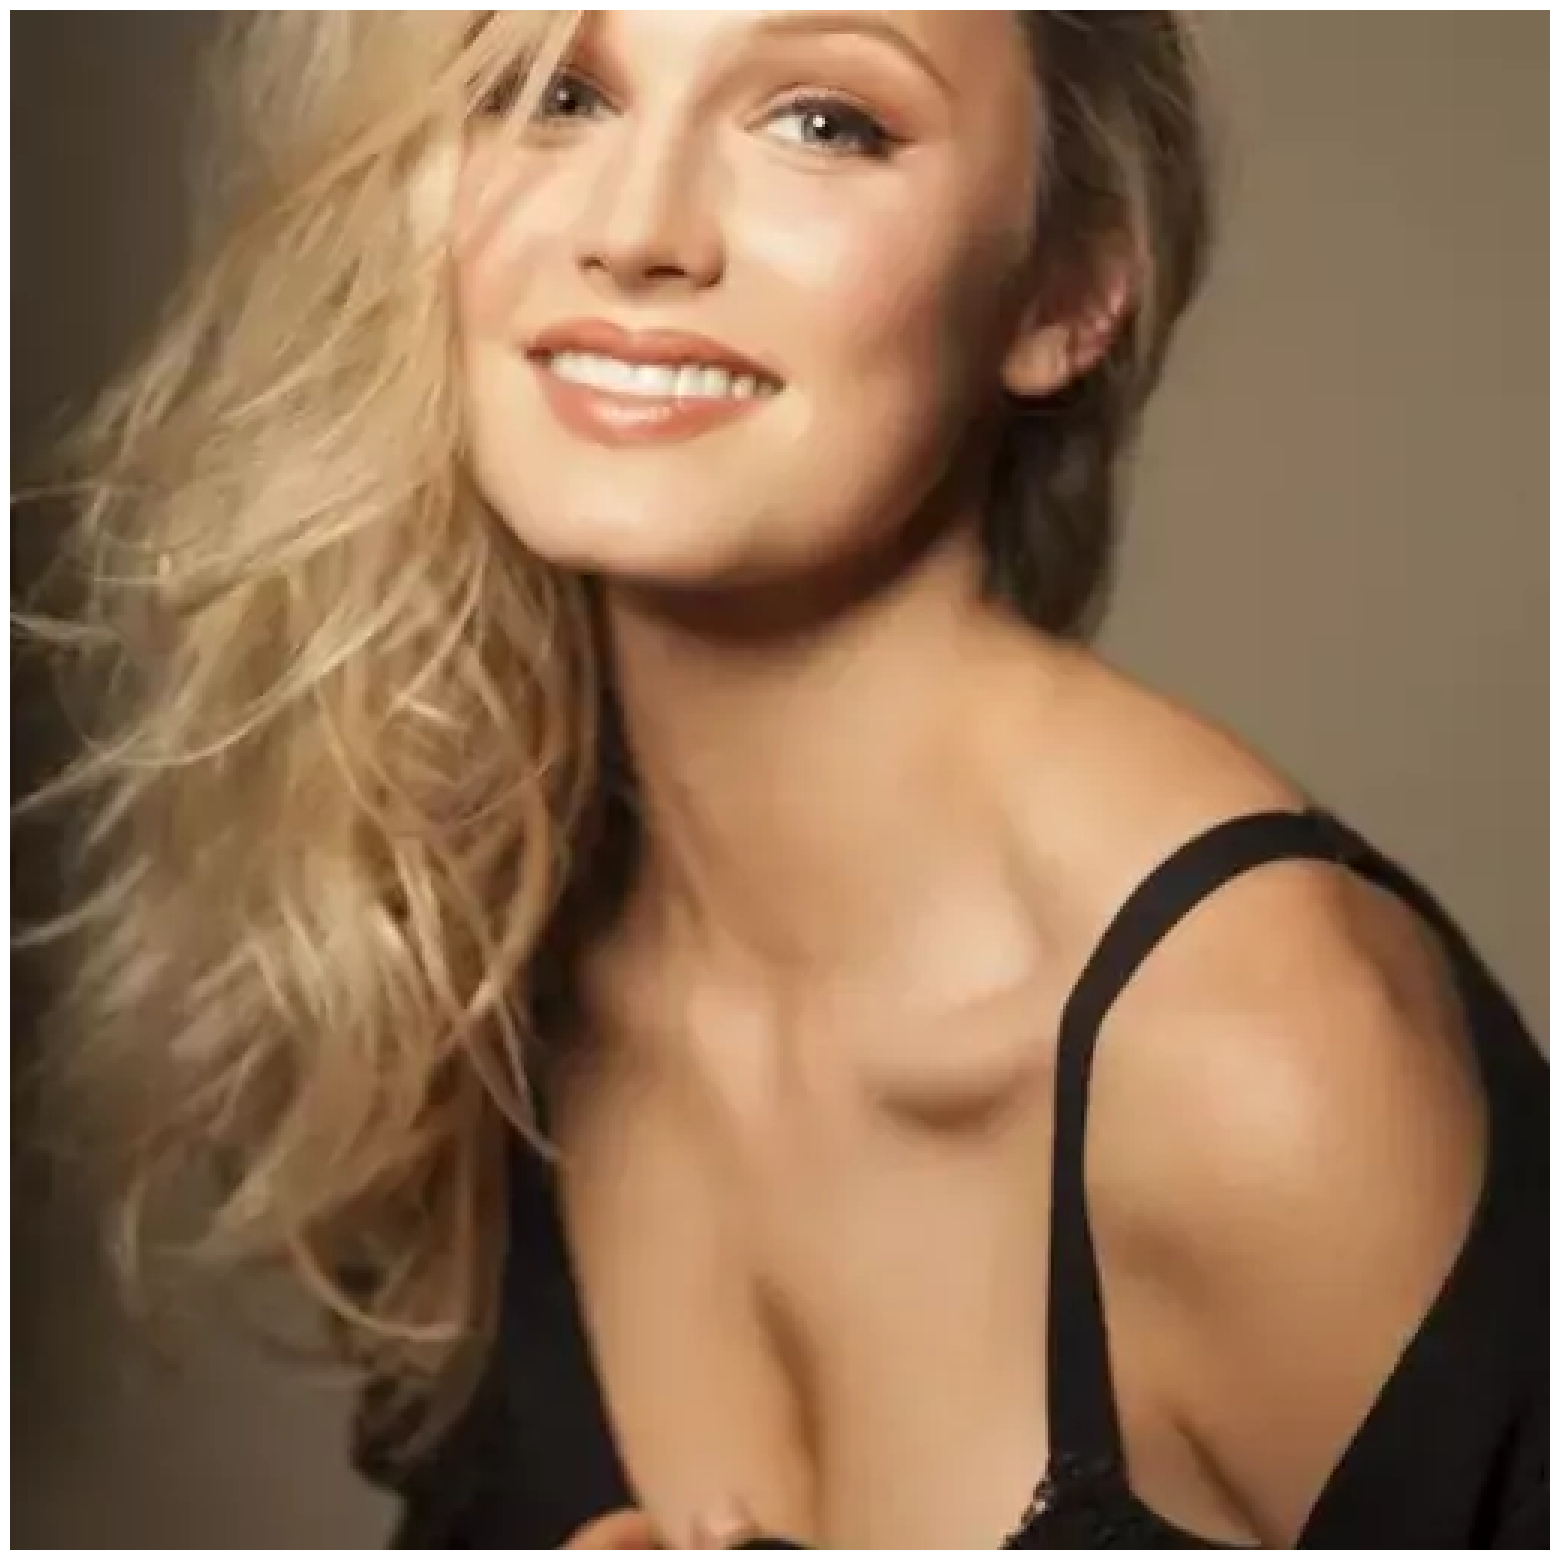

In [4]:
# image = cv2.imread('data/zd_testimgs/-663378304158021540.webp')
image = cv2.imread('data/zd_testimgs/-15714488383694269.webp')
image2 = cv2.imread('data/two_testimgs/-663378304158021540.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
print(image.shape)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
""" from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.file_list = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_list[idx])
        image = cv2.imread(img_path)
        print(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image
    
data_directory = "./data/zd_testimgs/"
dataset = CustomImageDataset(data_directory)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0) """

' from torch.utils.data import Dataset, DataLoader\n\nclass CustomImageDataset(Dataset):\n    def __init__(self, img_dir, transform=None):\n        self.img_dir = img_dir\n        self.transform = transform\n        self.file_list = os.listdir(self.img_dir)\n\n    def __len__(self):\n        return len(self.file_list)\n\n    def __getitem__(self, idx):\n        img_path = os.path.join(self.img_dir, self.file_list[idx])\n        image = cv2.imread(img_path)\n        print(img_path)\n        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n        if self.transform:\n            image = self.transform(image)\n        return image\n    \ndata_directory = "./data/zd_testimgs/"\ndataset = CustomImageDataset(data_directory)\ndataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0) '

In [6]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_h.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
model = sam.to(xm.xla_device())
model.eval()
sam_dynamo = torch.compile(model, backend='torchxla_trace_once')

<All keys matched successfully>


In [12]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam_dynamo,
    points_per_side=4,
    points_per_batch=16,
    min_mask_size=5000
)

In [13]:
def gen_masks():
    xp.trace('localhost:6009', logdir='/home/lodestone/sam-hq/', num_tracing_attempts=1, host_tracer_level=3, timeout_s=15, duration_ms=10000)
    print('Done tracing')
trace = False
if trace:
    p = multiprocessing.Process(target=gen_masks)
    p.start()
    server = xp.start_server(6009)
    time.sleep(5)

tensor1 = torch.as_tensor(image).permute(2, 0, 1).contiguous()[None, :, :, :]
tensor2 = torch.as_tensor(image2).permute(2, 0, 1).contiguous()[None, :, :, :]
#input = torch.cat([tensor1, tensor2], dim=0)
#print(input.shape)
masks, valid, count = mask_generator.generate(tensor2)
# print(f"got {valid.count_nonzero()} masks")
print(valid)
print(count)

torch_xla.core.xla_model::mark_step


tensor([ 4,  7,  1, 15,  5,  6,  2, 11,  3, 13, 14, 10,  0,  9, 12,  8],
       device='xla:0', dtype=torch.int32)
tensor(4, device='xla:0', dtype=torch.int32)


In [14]:
# kernel = torch.tensor(
#     [[[[0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
#        [0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0],
#        [0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0],
#        [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#        [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
#        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
#        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
#        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
#        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
#        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
#        [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#        [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0],
#        [0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0],
#        [0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0],
#        [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0]]]],
#     dtype=torch.bool, 
#     device=xm.xla_device()
# )

kernel = torch.tensor(
     [[[[0,1,1,1,0],
        [1,1,1,1,1],
        [1,1,1,1,1],
        [1,1,1,1,1],
        [0,1,1,1,0]]]],
    dtype=torch.bool, 
    device=xm.xla_device()
)

print(kernel.shape)
#masks_convolved = []
#for i in range(masks.shape[1]):
mask_convolving = masks.squeeze(0).unsqueeze(1)
print(mask_convolving.shape)
mask_convolving = ~mask_convolving
for i in range(1):
    mask_convolving = torch.nn.functional.conv2d(mask_convolving, kernel, padding=(2,2))
mask_convolving = ~mask_convolving
for i in range(6):
    mask_convolving = torch.nn.functional.conv2d(mask_convolving, kernel, padding=(2,2))
#masks_convolved.append(mask_convolving)
mask_convolving = mask_convolving.squeeze(1).unsqueeze(0)

#masks_convolved = torch.stack(masks_convolved,1)
print(mask_convolving.shape)


torch.Size([1, 1, 5, 5])
torch.Size([16, 1, 512, 512])
torch.Size([1, 16, 512, 512])


torch.Size([4, 512, 512])
(512, 512, 4)


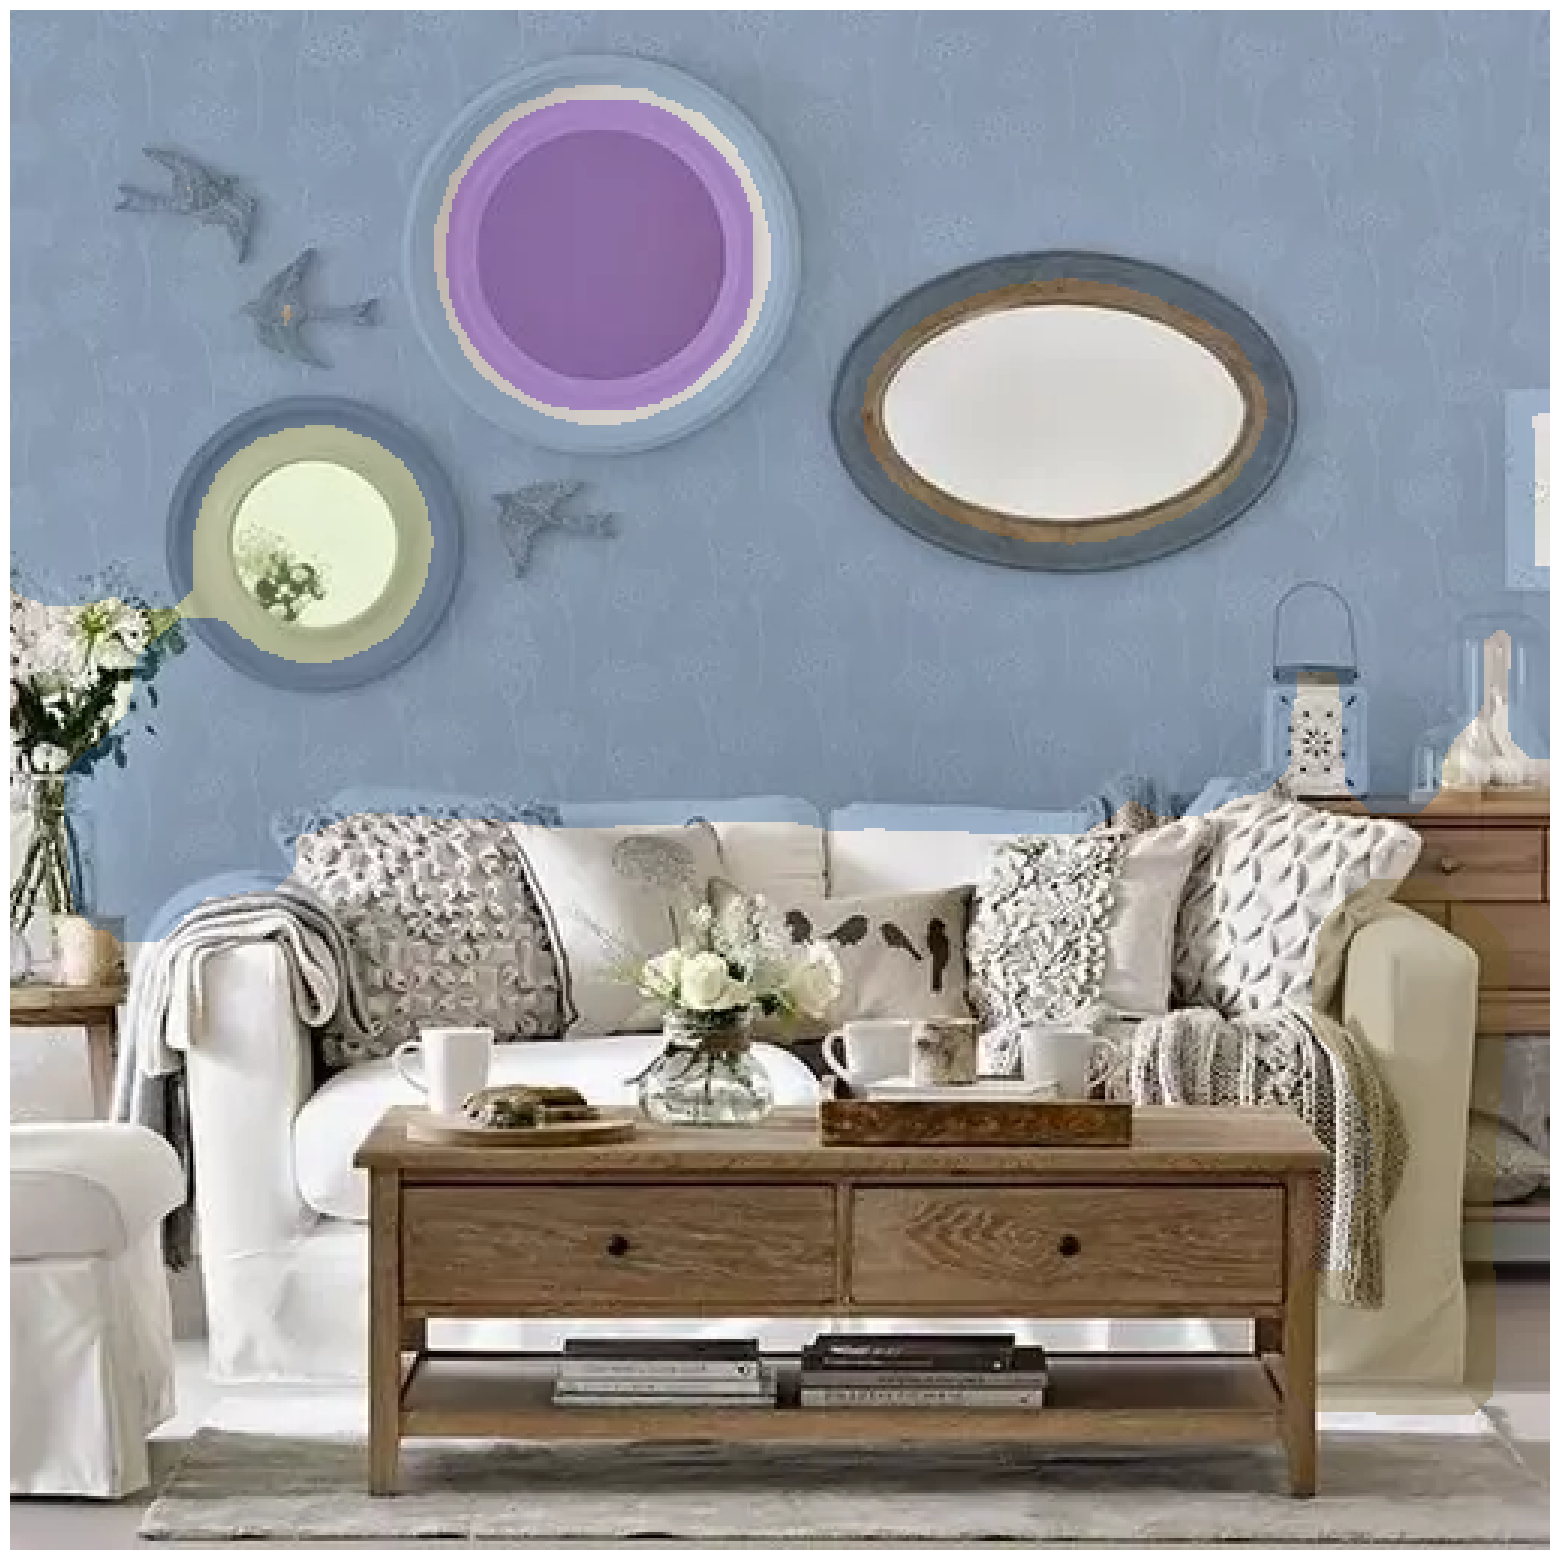

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(image2)
show_anns(mask_convolving, valid, count)
plt.axis('off')
plt.show()

In [11]:
import torch_xla.debug.metrics as met
print(met.metrics_report())
met.clear_all()

Metric: DeviceLockWait
  TotalSamples: 26
  Accumulator: 258.522us
  ValueRate: 008.667us / second
  Rate: 0.871654 / second
  Percentiles: 1%=001.674us; 5%=002.737us; 10%=003.398us; 20%=003.674us; 50%=009.214us; 80%=015.569us; 90%=016.116us; 95%=016.643us; 99%=032.062us
Metric: InputOutputAliasCount
  TotalSamples: 1
  Accumulator: 621.00
  Percentiles: 1%=621.00; 5%=621.00; 10%=621.00; 20%=621.00; 50%=621.00; 80%=621.00; 90%=621.00; 95%=621.00; 99%=621.00
Metric: IrValueTensorToXlaData
  TotalSamples: 693
  Accumulator: 01s321ms838.957us
  ValueRate: 035ms563.022us / second
  Rate: 18.1341 / second
  Percentiles: 1%=027.324us; 5%=031.407us; 10%=033.857us; 20%=038.539us; 50%=063.022us; 80%=417.880us; 90%=007ms145.060us; 95%=016ms211.862us; 99%=017ms627.441us
Metric: TensorToData
  TotalSamples: 717
  Accumulator: 01s320ms436.497us
  ValueRate: 034ms450.886us / second
  Rate: 18.7069 / second
  Percentiles: 1%=026.010us; 5%=029.886us; 10%=032.423us; 20%=036.990us; 50%=058.855us; 80%=26